# Ghana Health Facilities 

In [374]:
# Data libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import plotly.graph_objects as go 
import math as mt


# libraries for download the data 
import os 
from urllib.request import urlretrieve

# libraries for statistic 
from scipy.stats import t

# Libraries to normalize the data
from sklearn.preprocessing import StandardScaler

In [30]:
URL = 'https://data.gov.gh/sites/default/files/harvest_resources/HEALTH%2520FACILITIES%2520IN%2520GHANA.csv'

In [31]:
#urlretrieve(URL, 'FacilitiesHealth.csv')

In [32]:
def download_data(url = URL, filename = 'FacilitiesHealth.csv', force = False):
    if not os.path.exists(filename):
        urlretrieve(url, filename)
        
    if force == True:
        urlretrieve(url, filename)
        
    data = pd.read_csv('FacilitiesHealth.csv')
    return data 
        
        

In [91]:
data_facilities = download_data(force = True)
print(data_facilities.shape)
data_facilities.head()


(3756, 8)


,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098


In [92]:
#looking for null data 
for col in data_facilities.columns:
    print(col, data_facilities.loc[:,col].isnull().sum())

Region 0
District 0
FacilityName 0
Type 0
Town 153
Ownership 0
Latitude 24
Longitude 24


In the dataset exist a few null data but still can be used so won't be erased rigth now

In [93]:
# This are the all the rows with miss data 
rows_nullData = data_facilities.loc[data_facilities.loc[:,'Town'].isnull() | data_facilities.loc[:,'Latitude'].isnull() | data_facilities.loc[:,'Longitude'].isnull() | data_facilities.loc[:,'Type'].isnull() | data_facilities.loc[:,'Ownership'].isnull()]
rows_nullData.head()

,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude
357,Ashanti,Bosome Freho,Dunkura Health Centre,Health Centre,Dunkura,Government,NaN,NaN
358,Ashanti,Bosome Freho,Yapesa St.Mary Clinic,Clinic,Yapesa,CHAG,NaN,NaN
596,Ashanti,Kumasi Metropolitan,Amansie Enterprise Clinic,Clinic,NaN,Private,6.41500,-1.37548
626,Ashanti,Kumasi Metropolitan,Restoration Clinic,Clinic,NaN,Private,6.41500,-1.37548
645,Ashanti,Mampong Municipal,Calvary Health Service,Clinic,NaN,Private,7.03397,-1.24294


In [94]:
for col in ['Region', 'Type', 'Ownership']:
    print(col,  '\n', data_facilities.loc[:,col].value_counts(), '\n')

Region 
 Ashanti          658
Greater Accra    504
Western          496
Volta            398
Eastern          393
Brong Ahafo      348
Central          299
Northern         267
Upper East       232
Upper West       161
Name: Region, dtype: int64 

Type 
 Clinic                             1171
Health Centre                       786
CHPS                                652
Maternity Home                      369
Hospital                            277
RCH                                 152
District Health Directorate          99
District Hospital                    82
Training Institution                 74
Others                               31
Polyclinic                           16
Regional Hospital                     9
Regional Health Directorate           9
Municipal Health Directorate          7
Municipal Hospital                    4
Psychiatric Hospital                  3
Teaching Hospital                     3
Research Institution                  2
Centre                   

Exist a few errors in the dataset: 
-  Lot of values that only appears a few times in types and ownership.
-  Exist values that were wrote more than once but without capital letters. 
-  Exist repeated facilities
-  A few facilities have the wrong region

To correct this, first its necesary correct the values and then merge all values that have less than 50 to facilitate the analisis BUT this is only for a rough analysis of the general health facilities in the region not a specified analysis of wich types of facilities are needed according to the population needs, to do it will be necesary information about average situation of the patients and doctors.

In [152]:
# to correct the repeated values 
data_facilities.loc[:,'Type'] = data_facilities.loc[:,'Type'].str.lower()
data_facilities.loc[:,'Ownership'] = data_facilities.loc[:,'Ownership'].str.lower()
# In the previous code one of the rows with null data havent the most of the info so is discarted
data_facilities = data_facilities.drop(data_facilities.loc[data_facilities.loc[:,'Type'].isnull()].index)


#error: exist the same facilities writed more than once 
print(data_facilities.shape)
data_gh_clean = data_facilities.drop_duplicates(subset = ['FacilityName'], keep = 'first')
print(data_gh_clean.shape)
# I will consider the Regional Hospitals, Municipal Hospitals, Metropolitan Hospitals and Disrtric Hospitals as Hospitals, I will left
# apart the Psychiatric and Teaching hospitals because are to specializated in a single type of diseases.
data_facilities = data_facilities.replace({'district hospital':'hospital','municipal hospital': 'hospital', 'metropolitan hospital':'hospital', 'regional hospital':'hospital'})

#error: Are a few facilities excesiveley far from the others in the 'same' region


data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Bolgatanga Health Assistants Training School'].index, 'Region'] = 'Upper West'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Abu Clinic'].index, 'Region'] = 'Northern'

data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Asemnyinakrom Health Centre'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'New Papaase CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Nsowakrom CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Owusu Ansah CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Fosukrom CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Arhinful CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Amoashed CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Kwametawiahkrom CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Cashier CPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Eye Ewurade Maternity Home'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Kwasi Nkrumah CHPS'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'St. John of God Clinic Annex'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'St. Luke Methodist Clinic'].index, 'Region'] = 'Ashanti'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Presby Clinic'].index, 'Region'] = 'Ashanti'



data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Infirmary Clinic'].index, 'Region'] = 'Upper West'
data_facilities.loc[data_facilities.loc[data_facilities.FacilityName == 'Scho ol for the Deaf Clinic'].index, 'Region'] = 'Upper West'





(3756, 8)
(3544, 8)


In [153]:
# Assign all the values under 50 to "others"
temp = data_facilities.loc[:,'Type'].value_counts()
for idx in data_facilities.loc[:,'Type'].unique():
    if temp[idx] < 50:
        data_facilities.loc[(data_facilities.loc[:,'Type'] == idx), 'Type'] = 'others'
        
        
for idx in data_facilities.loc[:,'Ownership'].unique():
    temp = data_facilities.loc[:,'Ownership'].value_counts()
    if temp[idx] < 50:
        data_facilities.loc[(data_facilities.loc[:,'Ownership'] == idx), 'Ownership'] = 'others'
    
    

## Exploring the Data

With the clean dataset it can be seen the amount of facilities and wich types exist, this is relevant to determine the needs and the distribution of the facilities along the territory.

In the previous reduction of the types of facilities it was reduce to 9 types as follows:

In [154]:
data_facilities.loc[:,'Type'].unique()

array(['clinic', 'health centre', 'maternity home', 'chps', 'hospital',
       'others', 'rch', 'training institution',
       'district health directorate'], dtype=object)

Most of the facilities are dedicated to low-level of emergency events or to coordinate the implementation of prevention activities that are very important to reduce the probability of recurrent diseases. Count with this information then it can say that the most important facilities are the health center, the clinics and the hospitals assuming the need of facilities wich could treat patients urgencies.

In the next charts are represented the distributions of facilities per region in two ways a simple barplot and a heatmap where is easy to indentify the wich region have more facilities and wich type of facilities predominate per region. It can see how the most relevant facilities (hospitals, clinics, health center) predominate in all the country but only in general terms if we see closely, the majority of this facilities are in a concentrated in a few regions (principaly Ashanti and Greater Acra), meanwhile the other regions may have or may not the necesary facilities to handle all the probable urgencies. This distribution make clear the inequality among the countrie, also is important to mentioned that its not necesary to have exactly the same number of facilities in each region, this depends of demographic and economic features that aren't contemplated in this analysis.

In [155]:
#Sum of facilities by type in each region 
data_facilities_region = data_facilities.groupby(['Region','Type'])['Type'].count()
data_facilities_region = data_facilities_region.reset_index(name = 'Sum_Type')
data_facilities_region.head()

,Region,Type,Sum_Type
0,Ashanti,chps,22
1,Ashanti,clinic,271
2,Ashanti,district health directorate,2
3,Ashanti,health centre,137
4,Ashanti,hospital,104


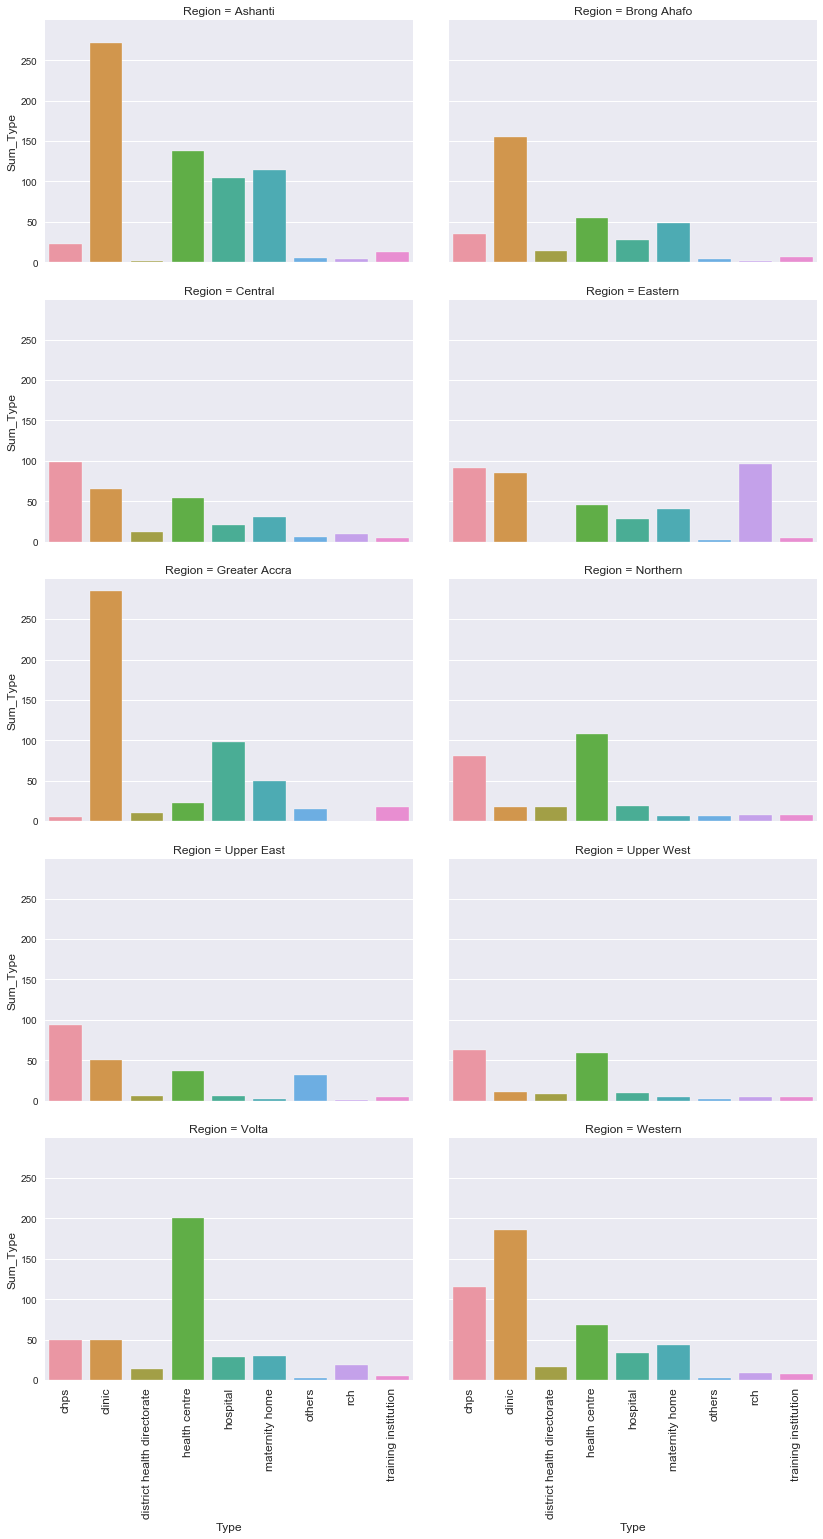

In [156]:
# Plot the number and type of facilities per region 
plt.style.use('seaborn')
region = sns.catplot( x = 'Type', y = 'Sum_Type', col = 'Region', data = data_facilities_region, kind = 'bar', height = 4, aspect = 1.5, col_wrap = 2, legend = True)

for axe in region.axes.flat:
    axe.set_title(axe.get_title(), fontsize = 12)
    axe.set_ylabel(axe.get_ylabel(), fontsize = 12)
    axe.set_xlabel(axe.get_xlabel(), fontsize = 12)
    #axe.set_yticklabels(axe.get_yticklabels(), rotation = 90, fontsize = 20)
    axe.set_xticklabels(axe.get_xticklabels(), rotation = 90, fontsize = 12)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text xticklabel objects>)

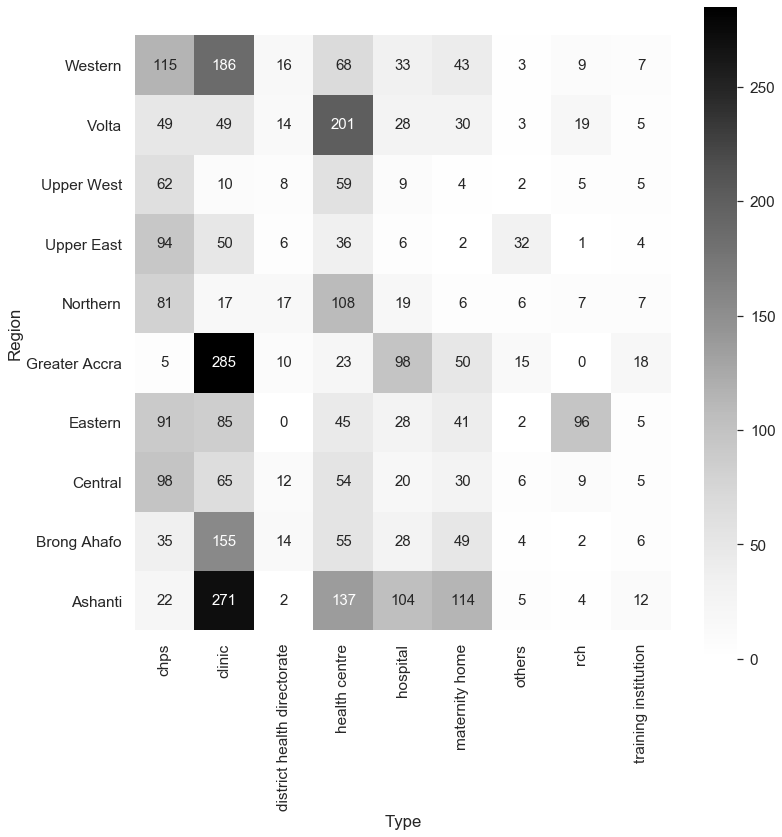

In [157]:
pivot_data_Facilities = pd.pivot_table(data_facilities_region, values = 'Sum_Type', index = ['Region'], columns = ['Type'])
#Exist some empty values, This will asume that if doesnt 
pivot_data_Facilities = pivot_data_Facilities.fillna(0)

plt.figure(figsize = (12,12))
sns.set(font_scale=1.4)
heat = sns.heatmap(pivot_data_Facilities, square = True, annot = True, annot_kws = {'size': 15},fmt ='g', cmap = 'Greys')

heat.set_ylim([0,10])
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

In [158]:
# table with resume 
max_region = []
for region in data_facilities_region.loc[:,'Region'].unique():
    idx = data_facilities_region.loc[data_facilities_region['Region'] == region].Sum_Type.idxmax()
    max_region.append ([region, data_facilities_region.loc[idx,'Type'], data_facilities_region.loc[idx,'Sum_Type']])

df_max_region = pd.DataFrame(max_region, columns = ['Region', 'Type', 'Sum_Type'])
df_max_region

,Region,Type,Sum_Type
0,Ashanti,clinic,271
1,Brong Ahafo,clinic,155
2,Central,chps,98
3,Eastern,rch,96
4,Greater Accra,clinic,285
5,Northern,health centre,108
6,Upper East,chps,94
7,Upper West,chps,62
8,Volta,health centre,201
9,Western,clinic,186


Here is respresented the proportions of facilities by their Ownership and by the their types and it can see some important facts about the data:

- Exist 2.4% of the facilities are quasi-goverment this mean a combination of private and public participation

- 31.4% are private facilities therefore aren't aviable for all the population, but definitely help to reduce the diseases dispersion at least in the population how can pay for it.

- Near to 30% of the overall facilities are destined to the "administration" of the resources and the improvement basic health culture.


In [159]:
def percentage_type(col_group, col_obj, data):
    data_group_type = data.groupby([col_group])[col_obj].count()
    data_group_type = data_group_type.apply(lambda x: (x/data_group_type.sum())*100)
    return data_group_type

In [160]:

data_ownership = percentage_type('Ownership', 'Type', data_facilities)
data_type = percentage_type('Type', 'Type', data_facilities)


Text(0.5, 1.0, 'Percentage of facilities by Types')

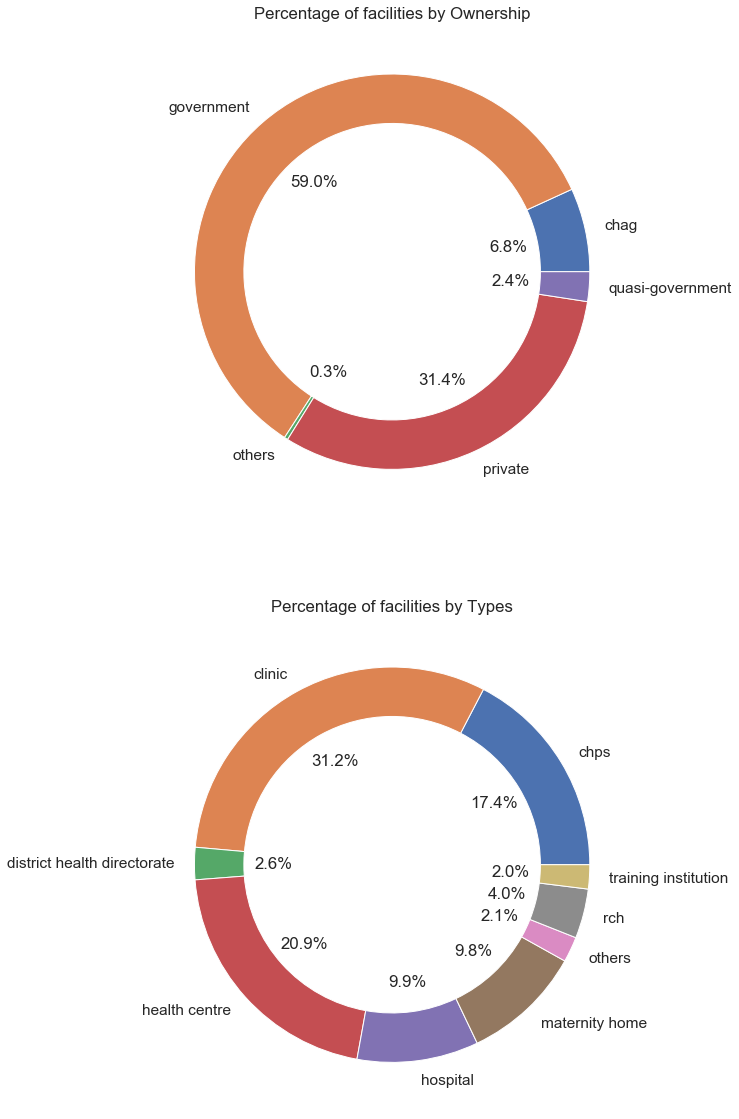

In [161]:
fig, ax = plt.subplots(2,1, figsize = (20,20))
ax[0].pie(data_ownership, labels = data_ownership.index, autopct = '%1.1f%%', wedgeprops=dict(width=0.25))
ax[0].set_title('Percentage of facilities by Ownership')
ax[1].pie(data_type, labels = data_type.index, autopct = '%1.1f%%', wedgeprops=dict(width=0.25))
ax[1].set_title('Percentage of facilities by Types')

In [130]:
#calculate the distance between two points with cardinal coordinates
def distance (lat1, log1, lat2, log2):
    ''' Function to calculate the dsitance between two points having the latitude and longitude
    lat1, lat2: latitude of the points
    log1, log2: longitude of the points
    
    note: the answer will be in kilometers'''
    radius = 6371 #radius of earth in km
    lat1_rad = mt.radians(lat1)
    lat2_rad = mt.radians(lat2)
    delta_lat = mt.radians(lat1-lat2)
    delta_log = mt.radians(log1-log2)
    
    a = mt.sin(delta_lat/2)**2 + (mt.cos(lat1_rad) * mt.cos(lat2_rad) * mt.sin(delta_log/2)**2)
    c = 2 * mt.atan2( mt.sqrt(a), mt.sqrt(1 - a))
    dist = radius * c
    
    return dist

In [131]:
def facilities_range(facilitie_one, facilitie_two, data):
    ''' Function to separate and calculate the distance between two types of facilities of the corresponding data
    facilitie_one: Name of the first facilitie 
    facilitie_two: Name of the second facilitie
    data: Data frame with the information '''
    data_dist = []
    data_pass = []
    for region in data.Region.unique():
        data_pass = data.loc[data.loc[:,'Region'] == region]
        data_pass_one = data_pass.loc[data_pass.loc[:,'Type'] == facilitie_one]
        data_pass_two = data_pass.loc[data_pass.loc[:,'Type'] == facilitie_two]
        for id1 in data_pass_one.index:
            for id2 in data_pass_two.index:
                lat1  = predominate_facilities.loc[id1, 'Latitude']
                long1 = predominate_facilities.loc[id1, 'Longitude']
                lat2  = predominate_facilities.loc[id2, 'Latitude']
                long2 = predominate_facilities.loc[id2, 'Longitude']
                dist_facilities = distance(lat1, long1, lat2, long2)
                name_one = predominate_facilities.loc[id1, 'FacilityName']
                name_two = predominate_facilities.loc[id2, 'FacilityName']
                data_dist.append([predominate_facilities.loc[id1, 'Region'], name_one, name_two, dist_facilities])
                
    df = pd.DataFrame(data_dist, columns = ['Region', facilitie_one, facilitie_two, 'Distance'])
    return df

In [132]:
def map_facilities(data, title):
    '''Function to plot the map of a dataframe
    data: Dataframe of interest
    title: title of the map'''
    #max locations to center the map plot 
    max_latitude = data.Latitude.max()
    min_latitude =  data.Latitude.min()
    max_longitude = data.Longitude.max()
    min_longitude =  data.Longitude.min()

    #if the color is not defined in dataset its easier to complete all the information requirements using 
    #for loop 
    map_facilities = []
    for index, region in enumerate(data.Region.unique()):
        map_facilities.append(
        go.Scattergeo(
                      lon = data.loc[data.Region == region].Longitude,
                      lat = data.loc[data.Region == region].Latitude,
                      text = data.loc[data.Region == region].FacilityName,
                      mode = 'markers',
                      marker_color = index,#data_gh_clean.loc[data_gh_clean.Region == region].index,
                      name = region
                      ))

    layout = dict(
                  title = title,
                  geo = dict(
                  scope = 'africa',
                  showland = True,
                  lonaxis = dict(
                                 showgrid = True,
                                 gridwidth = 0.5,
                                 range = [min_longitude - 1, max_longitude + 1],
                                 dtick = 5),
                  lataxis = dict(
                                 showgrid = True,
                                 gridwidth = 0.5,
                                 range = [min_latitude - 1, max_latitude + 1],
                                 dtick = 5),
                  landcolor = 'rgb(250, 250, 250)',
                  subunitcolor = 'rgb(217, 217, 217)',
                  countrycolor = 'rgb(217, 217, 217)',
                  countrywidth = 0.5,
                  subunitwidth = 0.5),)

    figure = dict( data = map_facilities, layout = layout)
    go.Figure(figure).show()
    

In [169]:
#Its necesary drop all the rows without Latitude or Longitude
miss_lat_long = data_facilities.loc[data_facilities.loc[:,'Latitude'].isnull() | data_facilities.loc[:,'Longitude'].isnull()]
data_facilities = data_facilities.drop(miss_lat_long.index)

In the next plot it can see how is the distribution of the facilities in the countrie divided by the regions, its necessary to mentionated that in this plot its all the clean dataframe including all types of facilities and the map confirms all the previous analysis, but still is a tricky view of the reality if we selected the "relevant" facilities its more clear the inequality.

- Map that includes all the facilities in the dataset.

In [170]:
map_facilities(data_facilities, 'Facilities per Region in Ghana')


- The map have the information about the clinics and health centers.

In [171]:
clinics_health = data_facilities.loc[(data_facilities.Type == 'clinic') | (data_facilities.Type == 'health centre')] # | (data_facilities.Type == 'hospital')]
map_facilities(clinics_health, 'Clinics and Health Centre in Ghana per Region')

- The map have the information about the hospitals and clinics.

In [172]:
hospital_clinics = data_facilities.loc[(data_facilities.Type == 'clinic') | (data_facilities.Type == 'hospital')] # | (data_facilities.Type == 'hospital')]
map_facilities(hospital_clinics, 'Hospitals and Clinics in Ghana per Region')

- The map have the information about hospitals, clinics and health center managed by the goverment and quasi-goverment.

In [173]:
goverment_facilities = data_facilities.loc[((data_facilities.Ownership == 'goverment') | (data_facilities.Ownership == 'quasi-goverment')) & ( (data_facilities.Type == 'clinic') | (data_facilities.Type == 'hospital') | (data_facilities.Type == 'health centre'))]
map_facilities(hospital_clinics, 'Hospitals and Clinics in Ghana per Region')

In the maps it can see how the amount of facilities is drasticaly reduced if its apply the conditionals mentioned specialy the last two. Almost the half part of the country lacks of the necesary infrastructure to handle the health care of the population.

In the next part it will be calculated the distance between facilities in order of the priority of the facilites assuming that the first line of attendance will be the health center then the clinics and finaly the hospitals, considering common diseases in ghana and not a extremly specializated ones like mental issues.

In [174]:
#Calculate the distances between Clinics - Health Center and Hospitals - Clinics 
#assuming this hierarchy by the order of capacities of the facilities
predominate_facilities = data_facilities.loc[(data_facilities.Type == 'clinic') | (data_facilities.Type == 'health centre') | (data_facilities.Type == 'hospital')]

In [175]:
distance_Clinics_Health = facilities_range('clinic', 'health centre', predominate_facilities)
distance_Hospitals_Clinics = facilities_range('hospital', 'clinic', predominate_facilities)

Text(355.98863636363626, 0.5, 'Mean Distance')

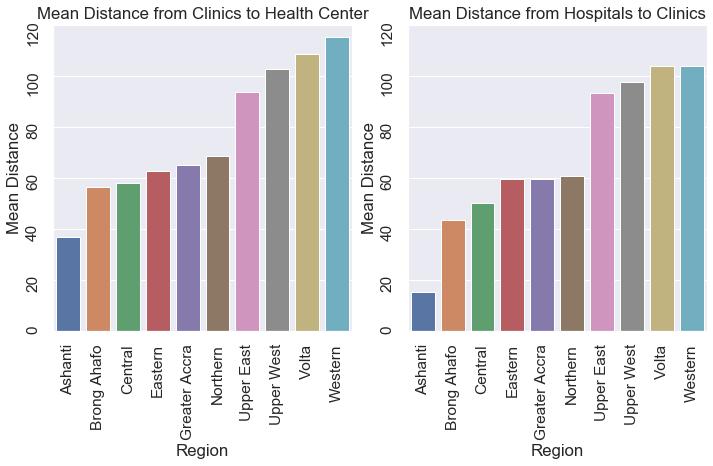

In [283]:
stats_clinic_health = distance_Clinics_Health.groupby(['Region'], as_index = False).Distance.agg(['mean','std', 'count'])
stats_hospital_clinic = distance_Hospitals_Clinics.groupby(['Region'], as_index = False).Distance.agg(['mean','std', 'count'])

fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.tight_layout()
sns.barplot(x = stats_clinic_health.index, y = stats_clinic_health['mean'].sort_values(), ax = ax[0,])
ax[0].set_title('Mean Distance from Clinics to Health Center')
ax[0].tick_params(labelrotation=90)
ax[0].set_ylim([0,120])
ax[0].set_ylabel('Mean Distance')
sns.barplot(x = stats_hospital_clinic.index, y = stats_hospital_clinic['mean'].sort_values(), ax = ax[1])
ax[1].set_title('Mean Distance from Hospitals to Clinics')
ax[1].tick_params(labelrotation=90)
ax[1].set_ylim([0,120])
ax[1].set_ylabel('Mean Distance')


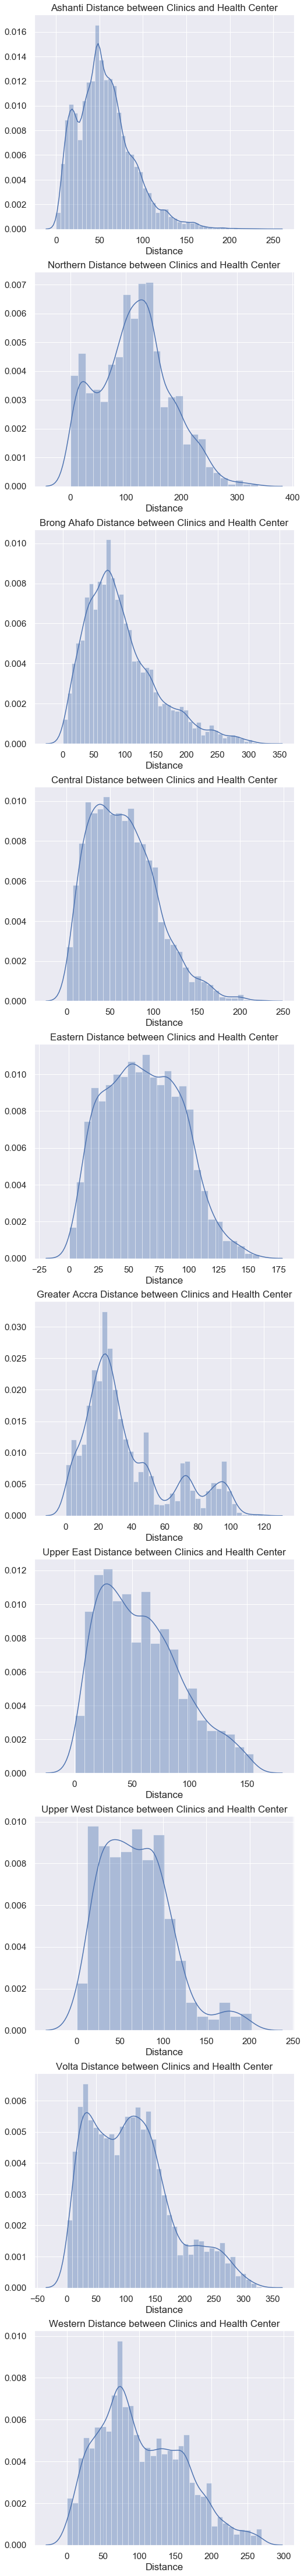

In [222]:
fig, ax = plt.subplots(10,1, figsize = (8,80))
val = 0
for region in predominate_facilities.Region.unique():
    data = distance_Clinics_Health.loc[distance_Clinics_Health.loc[:,'Region'] == region].Distance 
    sns.distplot(data, ax = ax[val])
    ax[val].set_title(region + ' Distance between Clinics and Health Center')
    val = val + 1 
    

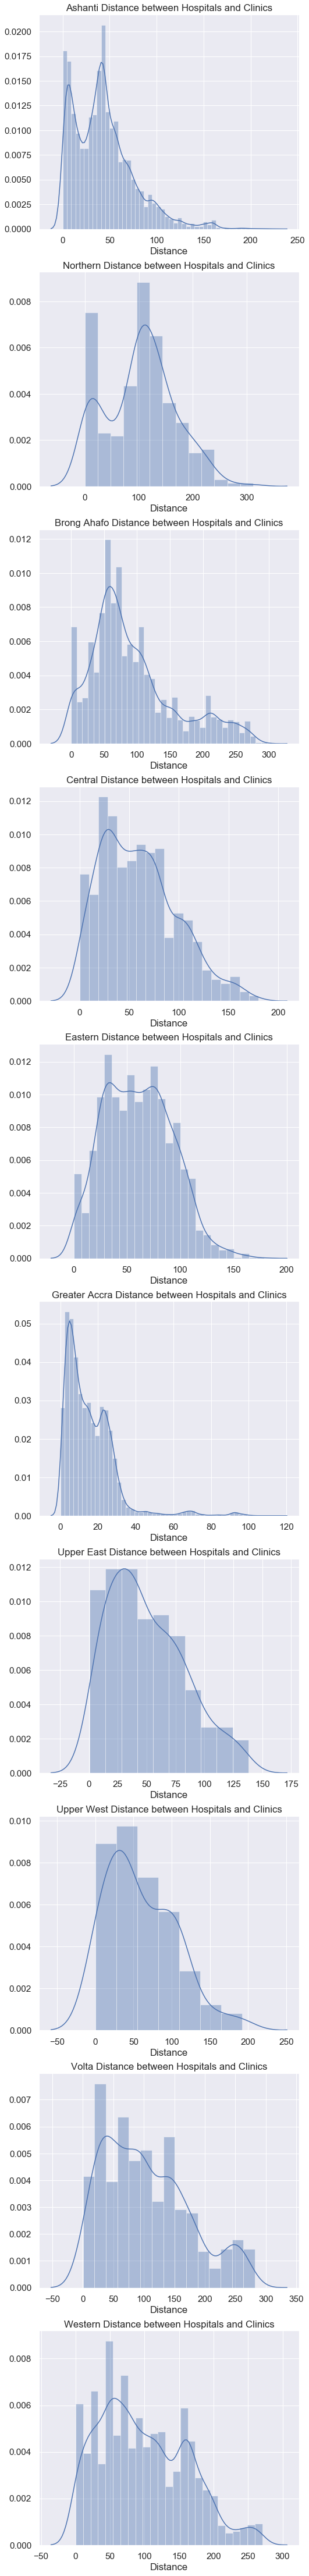

In [223]:
fig, ax = plt.subplots(10,1, figsize = (8,80))
val = 0
for region in predominate_facilities.Region.unique():
    data = distance_Hospitals_Clinics.loc[distance_Hospitals_Clinics.loc[:,'Region'] == region].Distance 
    sns.distplot(data, ax = ax[val])
    ax[val].set_title(region + ' Distance between Hospitals and Clinics')
    val = val + 1 

In [343]:
# add the distance normalize per region.
#distance_Clinics_Health['Dist_norm'] = distance_Clinics_Health.groupby(['Region']).Distance.apply(lambda x: ((x - x.mean())/x.std()) )

In [381]:
stats_clinic_health

,mean,std,count
Region,,,
Ashanti,56.310209,32.071694,36720
Brong Ahafo,93.823352,57.769005,8525
Central,64.972535,38.108218,3510
Eastern,62.574903,31.571337,3780
Greater Accra,36.650618,26.161203,6555
Northern,115.463683,64.655859,1712
Upper East,58.049357,35.390917,1800
Upper West,68.546395,39.935658,590
Volta,108.728736,70.096907,9849


In [452]:
#  Null Hypothesys M1-M2 = 0 
#  Alternative Hypothesis M1-M2 > 0
#  Assuming the variance is different and unknown 
def hypothesis_test(data):
    hypo_clinics = []
    list_region2 = list(data.index)
    alpha = 0.05
    
    for region in data.index:
        m1 = data.loc[region,'mean']
        s1 = data.loc[region,'std']
        n1 = data.loc[region,'count']
        list_region2.remove(region)
        
        for region2 in list_region2:

            m2 = data.loc[region2,'mean']
            s2 = data.loc[region2,'std']
            n2 = data.loc[region2,'count']
            deg_f = (( (s1**2)/n1 + (s2**2)/n2 ) ** 2) / (( ((s1**2)/n1)**2 ) /( n1 - 1 ) + ( ((s2**2)/n2)**2 ) /( n2 - 1 ))
            T = (m1 - m2) / np.sqrt(((s1**2)/n1) + ((s2**2)/n2))
            t_val = t.ppf(1 - alpha,df = deg_f)
            p = 1 - t.cdf(abs(T),df = deg_f)
            hypo_clinics.append([region,region2,deg_f,T,t_val,p])
    
    Hypothesis =pd.DataFrame(hypo_clinics, columns = ['Region_1', 'Region_2','Degrees_free','T_value','Critical_val', 'Significance_p'])
    
    return Hypothesis


In [453]:
hypothesis_clinic_health = hypothesis_test(stats_clinic_health)
hypothesis_clinic_health

,Region_1,Region_2,Degrees_free,T_value,Critical_val,Significance_p
0,Ashanti,Brong Ahafo,9775.910944,-57.919969,1.645010,0.000000e+00
1,Ashanti,Central,3998.475906,-13.032992,1.645235,0.000000e+00
2,Ashanti,Eastern,4619.166539,-11.599255,1.645184,0.000000e+00
3,Ashanti,Greater Accra,10408.712438,54.024963,1.645000,0.000000e+00
4,Ashanti,Northern,1750.470712,-37.639806,1.645725,0.000000e+00
5,Ashanti,Upper East,1946.601685,-2.044141,1.645637,2.053695e-02
6,Ashanti,Upper West,601.269433,-7.404105,1.647392,2.239320e-13
7,Ashanti,Volta,10975.660933,-72.213700,1.644992,0.000000e+00
8,Ashanti,Western,13649.116548,-80.963645,1.644965,0.000000e+00
9,Brong Ahafo,Central,9711.524730,32.151674,1.645011,0.000000e+00


In [454]:
hypothesis_hospital_clinic = hypothesis_test(stats_hospital_clinic)
hypothesis_hospital_clinic

,Region_1,Region_2,Degrees_free,T_value,Critical_val,Significance_p
0,Ashanti,Brong Ahafo,4677.837111,-49.526824,1.645179,0.000000e+00
1,Ashanti,Central,1386.899292,-15.224684,1.645953,0.000000e+00
2,Ashanti,Eastern,2778.420753,-25.429135,1.645402,0.000000e+00
3,Ashanti,Greater Accra,37382.379591,134.063063,1.644894,0.000000e+00
4,Ashanti,Northern,288.514962,-16.024690,1.650152,0.000000e+00
5,Ashanti,Upper East,305.224170,-3.592664,1.649861,1.907017e-04
6,Ashanti,Upper West,89.291495,-3.405836,1.662098,4.951855e-04
7,Ashanti,Volta,1399.608312,-31.783938,1.645943,0.000000e+00
8,Ashanti,Western,6349.987403,-63.161111,1.645094,0.000000e+00
9,Brong Ahafo,Central,3695.343435,23.061830,1.645266,0.000000e+00


http://www.nationalplanningcycles.org/sites/default/files/planning_cycle_repository/ghana/hsmtdp_2014-2017_final_draft_9_oct.pdf